<a href="https://colab.research.google.com/github/luvitale/SOA_HPC/blob/main/low_pass_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

## Filtro utilizado en los casos

> Para los siguientes casos se utilizará el filtro Low Pass Filter.

>Low Pass Filter realiza un filtrado en la imagen, utilizando una matriz máscara, que realizará una conversión de valor en cada uno de sus píxeles, para tener una imagen más *borrosa* pero que eliminará el ruido de la imagen y permitirá ver detalles que antes no eran visibles.

> Se utilizará la técnica convolution para obtener la matriz resultado.

## Convolution

> La técnica consiste en tomar cada píxel de una matriz y calcularle un nuevo valor multiplicándolo por una matriz máscara. El nuevo valor del píxel será la suma del píxel y sus vecinos multiplicados por el valor de la matriz máscara en esa posición.

> Se utiliza la siguiente fórmula:

> ![Imagen Convolution](https://wikimedia.org/api/rest_v1/media/math/render/svg/0f0005a6520eaab36f9b30520b640663d669d891)

> En la imagen la primera matriz corresponde a la de la imagen y la segunda a la matriz máscara.

> Para estos casos aplicaremos el Low Pass Filter por medio de esta matriz máscara:

> ```python
[
  [ 0,  1/8,  0 ],
  [1/8, 1/4, 1/8],
  [ 0,  1/8,  0 ]
]
```

# Armado del ambiente

Para el armado del ambiente se necesita una imagen y se necesita instalar pycuda para la implementación en GPU.

In [4]:
#@markdown ---
#@markdown ### Especificá la URL de la imagen

image_url = "https://i.stack.imgur.com/f6cBP.jpg" #@param {type: "string"}

#https://cdn.diffractionlimited.com/help/maximdl/image/M81Before.png
#@markdown --- 

# Read image from internet.
!wget {image_url} -O image.jpg

--2021-07-17 01:19:16--  https://i.stack.imgur.com/f6cBP.jpg
Resolving i.stack.imgur.com (i.stack.imgur.com)... 151.101.40.193
Connecting to i.stack.imgur.com (i.stack.imgur.com)|151.101.40.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31895 (31K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  31.15K  --.-KB/s    in 0.04s   

2021-07-17 01:19:17 (762 KB/s) - ‘image.jpg’ saved [31895/31895]



In [2]:
!pip install pycuda

     |████████████████████████████████| 1.7MB 5.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 9.8MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627849 sha256=d151fe47c83eae23f125c954744753a93bdc884e9bd9143222a425cac9b40819
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=90fcc3e5c58c2815525c9585c6403e927fc96828db36a939a8e4a7ed477f447e
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


# Implementación en CPU con Python

Tiempo transcurrido: 0:00:02.634779



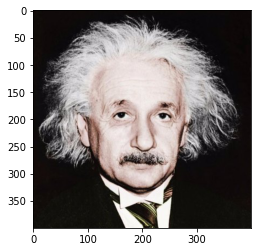

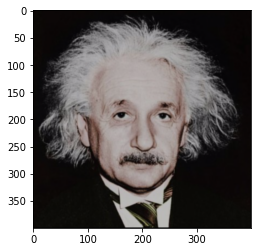

In [38]:
from PIL import Image, ImageDraw
from datetime import datetime
import  matplotlib.pyplot as plt

initial_cpu_img_time = datetime.now()

# Define colors index
RED = 0
GREEN = 1
BLUE = 2

# Load image:
img_name = 'image.jpg'
input_image = Image.open(img_name) 

# Array with input image pixels
input_image_pixel = input_image.load()

# Low Pass Filter convolution mask
low_pass_filter_mask = [
  [ 0,  1/8,  0 ],
  [1/8, 1/4, 1/8],
  [ 0,  1/8,  0 ]
]

# Select mask here:
mask = low_pass_filter_mask

# Middle of the kernel
offset = len(mask) // 2

# Create output image
output_image = Image.new("RGB", input_image.size)

# Element to draw output image
output_image_draw = ImageDraw.Draw(output_image)

# Compute convolution between intensity and mask
for x in range(offset, input_image.width - offset):
    for y in range(offset, input_image.height - offset):
        acc = [0, 0, 0]
        for a in range(len(mask)):
            for b in range(len(mask)):
                xn = x + a - offset
                yn = y + b - offset
                pixel = input_image_pixel[xn, yn]
                acc[RED] += pixel[RED] * mask[a][b]
                acc[GREEN] += pixel[GREEN] * mask[a][b]
                acc[BLUE] += pixel[BLUE] * mask[a][b]

        output_image_draw.point(
            (x, y), (int(acc[0]), int(acc[1]), int(acc[2]))
        )

total_cpu_img_time = datetime.now() - initial_cpu_img_time

print("Tiempo transcurrido: " + str(total_cpu_img_time) + "\n")

plt.figure()
imgplot=plt.imshow(input_image)
plt.figure()
imgplot=plt.imshow(output_image)